In [93]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import plot_model,model_to_dot
from keras.callbacks import ReduceLROnPlateau
import pydot
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image


## Load and visualize the dataset"

In [8]:
data_dir = "D:/indirilenler/archive/OCT2017/"
train_data_dir = "D:/indirilenler/archive/OCT2017/train/"
val_data_dir = "D:/indirilenler/archive/OCT2017/val/"
test_data_dir = "D:/indirilenler/archive/OCT2017/test/"

In [12]:
img_width = 150
img_height = 150
channels = 3
batch_size = 32
dropout_value = 0.2
epochs = 50

'img_width = 150\nimg_height = 150\nchannels = 3\nbatch_size = 32\ndropout_value = 0.2\nepochs = 50\n'

In [42]:
classList = os.listdir(train_data_dir)
print("Tespit Edilen Toplam Sınıf Sayısı: :",len(classList))

Tespit Edilen Toplam Sınıf Sayısı: : 4


In [44]:
nclasses= len(classList)
print(classList)
print("Sınıflar Yükleniyor")

['CNV', 'DME', 'DRUSEN', 'NORMAL']
Sınıflar Yükleniyor


In [43]:
# Print the number of images in each class

for folder in os.listdir(train_data_dir):
    print(f" {folder} sınıfındaki toplam görüntü sayısı: {len(os.listdir(os.path.join(train_data_dir, folder)))}")

 CNV sınıfındaki toplam görüntü sayısı: 37205
 DME sınıfındaki toplam görüntü sayısı: 11348
 DRUSEN sınıfındaki toplam görüntü sayısı: 8616
 NORMAL sınıfındaki toplam görüntü sayısı: 26315


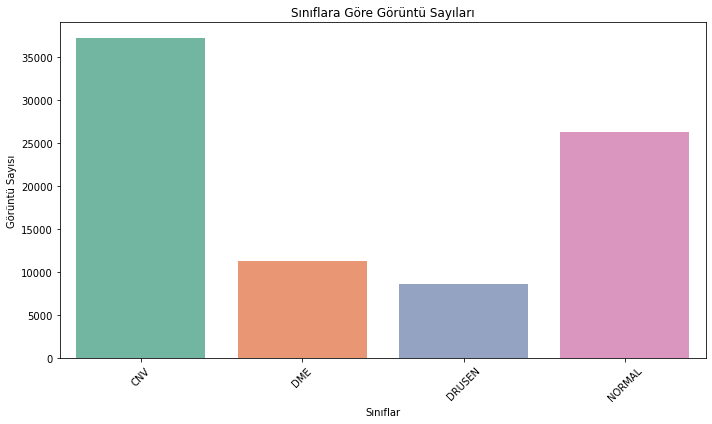

In [50]:
# Visualization of image numbers in classes

train_data_dir = "D:/indirilenler/archive/OCT2017/train/" 
class_names = []
image_counts = []

for folder in os.listdir(train_data_dir):
    class_names.append(folder)
    image_counts.append(len(os.listdir(os.path.join(train_data_dir, folder))))

color_palette = sns.color_palette("Set2", len(class_names)) 
fig = plt.figure(figsize=(10, 6))  

sns.barplot(x=class_names, y=image_counts, palette=color_palette) 
plt.xlabel('Sınıflar')
plt.ylabel('Görüntü Sayısı')
plt.title('Sınıflara Göre Görüntü Sayıları')

plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show()


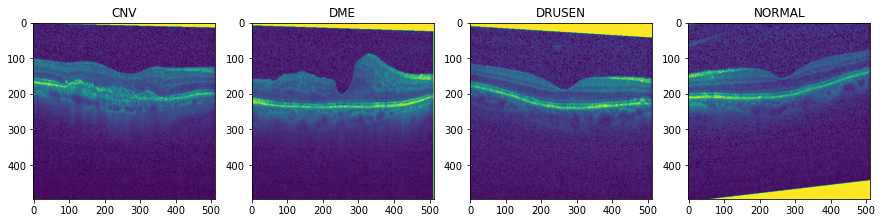

In [58]:
# Visualize sample images from each class

fig, axes = plt.subplots(1, 4, figsize=(15, 15))
for i, folder in enumerate(os.listdir(train_data_dir)):
    sample_image = os.listdir(os.path.join(train_data_dir, folder))[0]
    img = plt.imread(os.path.join(train_data_dir, folder, sample_image))
    axes[i].imshow(img)
    axes[i].set_title(folder)
plt.show()

In [51]:
# Display counts for train, test and val

def get_total_image_count(directory):
    total_count = 0
    for root, dirs, files in os.walk(directory):
        total_count += len(files)
    return total_count

train_image_count = get_total_image_count(train_data_dir)
val_image_count = get_total_image_count(val_data_dir)
test_image_count = get_total_image_count(test_data_dir)

print("Train veri setindeki toplam görüntü sayısı:", train_image_count)
print("Val veri setindeki toplam görüntü sayısı:", val_image_count)
print("Test veri setindeki toplam görüntü sayısı:", test_image_count)

Train veri setindeki toplam görüntü sayısı: 83484
Val veri setindeki toplam görüntü sayısı: 32
Test veri setindeki toplam görüntü sayısı: 968


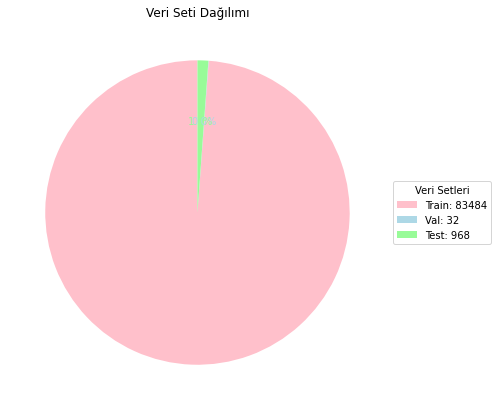

In [52]:
# Visualization of dataset distribution

image_counts = [train_image_count, val_image_count, test_image_count]
dataset_names = ["Train", "Val", "Test"]

colors = ['#FFC0CB', '#ADD8E6', '#98FB98']
fig, ax = plt.subplots(figsize=(7, 7))
_, _, autotexts = ax.pie(image_counts, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
legend_labels = [f"{name}: {count}" for name, count in zip(dataset_names, image_counts)]
plt.legend(legend_labels, title="Veri Setleri", loc="center left", bbox_to_anchor=(1, 0.5), prop={'size': 10})

for autotext, color in zip(autotexts, colors):
    autotext.set_color(color)

plt.title("Veri Seti Dağılımı")
plt.show()

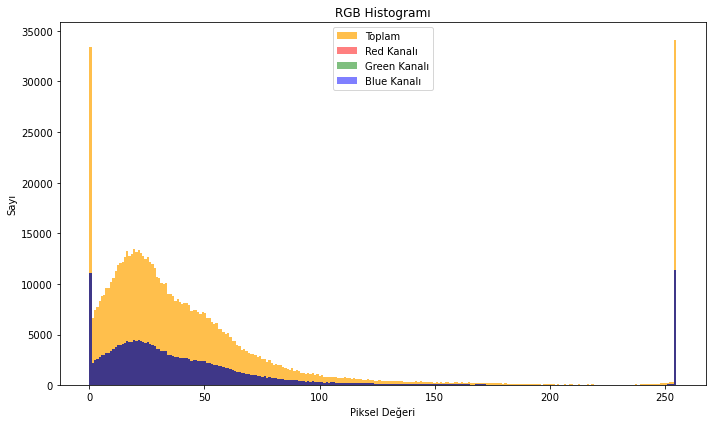

In [57]:
# RGB histogram of a retina in the training dataset

image_path = data_dir + 'train/NORMAL/NORMAL-1001666-1.jpeg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

red_channel = image_rgb[:, :, 0]
green_channel = image_rgb[:, :, 1]
blue_channel = image_rgb[:, :, 2]

plt.figure(figsize=(10, 6))
plt.hist(image_rgb.ravel(), bins=256, color='orange', alpha=0.7, label='Toplam')
plt.hist(red_channel.ravel(), bins=256, color='red', alpha=0.5, label='Red Kanalı')
plt.hist(green_channel.ravel(), bins=256, color='green', alpha=0.5, label='Green Kanalı')
plt.hist(blue_channel.ravel(), bins=256, color='blue', alpha=0.5, label='Blue Kanalı')

plt.xlabel('Piksel Değeri')
plt.ylabel('Sayı')
plt.title('RGB Histogramı')
plt.legend()
plt.tight_layout()

plt.savefig('histogram.png', transparent=False, bbox_inches='tight', dpi=400)
plt.show()


# Data augmentation

In [60]:
# Create an ImageDataGenerator for data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.10,
    shear_range=0.2,
    zoom_range= (0.73, 0.9),
    brightness_range= (0.55, 0.9),  
    horizontal_flip=True,
    fill_mode='constant'
)

In [22]:
# Create ImageDataGenerators for validation and test sets (without augmentation)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [62]:
# Create data generators for each set

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode= 'rgb',
    class_mode='categorical',
    shuffle= True, 
    seed= 1337
)


Found 83484 images belonging to 4 classes.


In [64]:
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode= 'rgb',
    class_mode='categorical',
    shuffle= True, 
    seed= 1337
)


Found 32 images belonging to 4 classes.


In [66]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode= 'rgb',
    class_mode='categorical',
     shuffle= True, 
    seed= 1337
)

Found 968 images belonging to 4 classes.


# Visualize the augmented images

In [68]:
# Function to visualize augmented images

def plot_augmented_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].set_title(titles[i])
    plt.show()

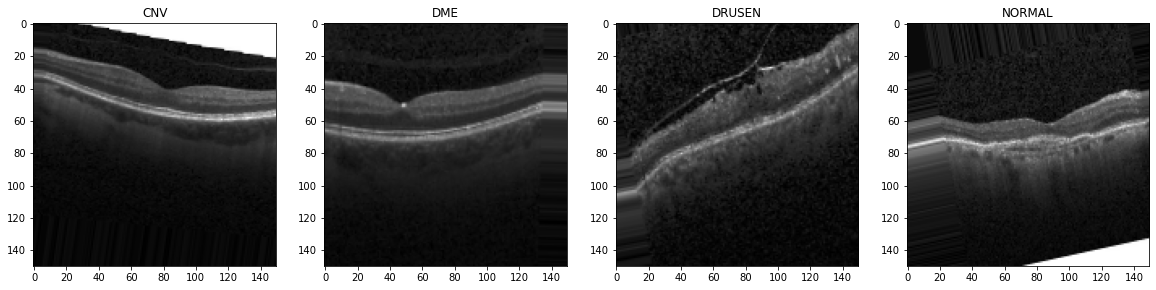

In [32]:
# Get a batch of augmented images

augmented_images, _ = next(train_generator)
plot_augmented_images(augmented_images[:4], ['CNV', 'DME', 'DRUSEN', 'NORMAL'])

# MODEL

In [71]:
# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, channels))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [76]:
# Create a custom model

model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

In [78]:
# Freeze the base model layers

for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)      

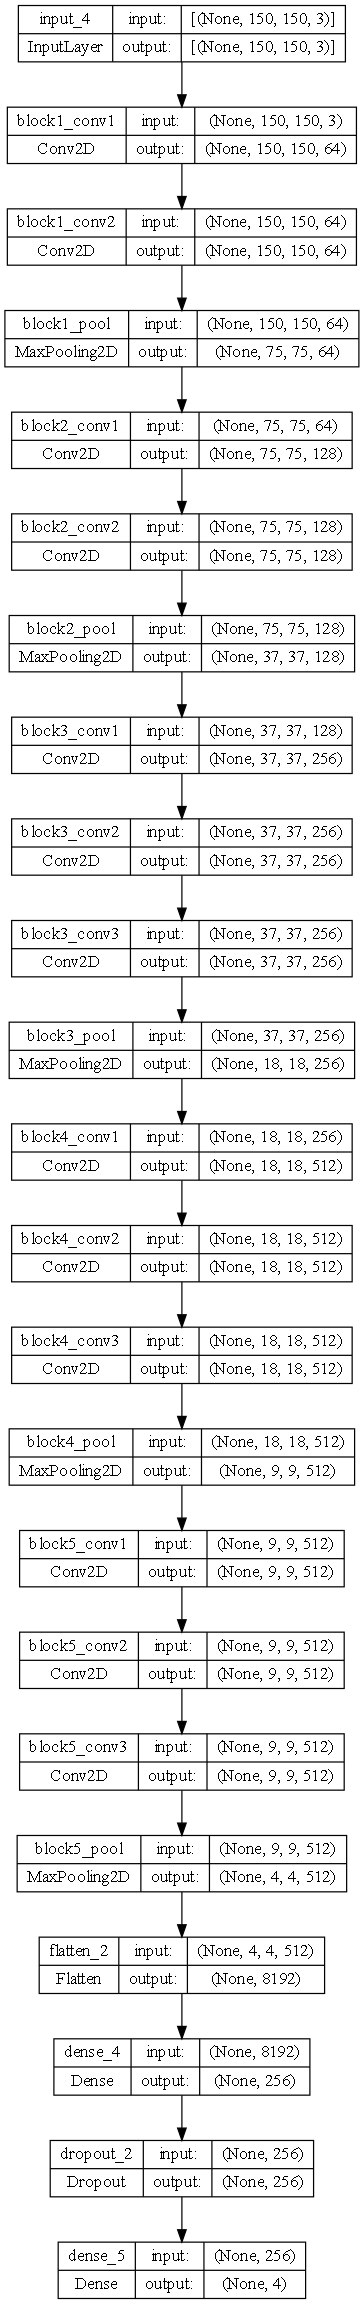

In [85]:
dot = model_to_dot(model, show_shapes=True, show_layer_names=True, expand_nested=True)
pydot_graph = pydot.graph_from_dot_data(dot.to_string())
pydot_graph[0].set_size('"24,24!"')
Image(pydot_graph[0].create_png())


In [86]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
# Defining callback functions

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.001,
    verbose=1,
    mode='auto'
    
)

tensorboard = TensorBoard(log_dir='./logs', 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

model_checkpoint = ModelCheckpoint(
    'baseline_model.h5', 
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    mode='auto',
    period=1
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    cooldown=2,
    patience=3,
    verbose=1, 
    mode='auto',
)
callbacks = [early_stopping, tensorboard, model_checkpoint, reduceLR]

In [ ]:
#Train the model:

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_steps = nb_valid_samples//batch_size,
    verbose=2,
    shuffle=True,
    callbacks=callbacks
)

In [ ]:
# Evaluate the model on the test set

test_loss, test_accuracy = model.evaluate(test_generator, batch_size= batch_size,)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

In [ ]:
# Drawing the model graph

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.title('Baseline Model Accuracy'),
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training Accuracy','Validation Accuracy'])
    plt.savefig('baseline_accuracy.png', transparent= False, bbox_inches= 'tight', dpi= 400)
    
    plt.subplot(1, 2, 2)
    plt.title('Baseline Model Loss'),
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training Loss','Validation Loss'])
    
    plt.show()

plot_history(history)

In [ ]:
# Activation and recompilation of parameters (trainable)

for layer in model.layers:
    layer.trainable = True
    
optimizer = optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='loss',
    patience=3,
    min_delta=0.001,
    verbose=1,
    mode='auto'
    
)

tensorboard = TensorBoard(log_dir='./logs', 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

model_checkpoint = ModelCheckpoint(
    'second_model.h5', 
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1
)

reduceLR = ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    cooldown=2,
    patience=3,
    verbose=1, 
    mode='auto',
)
callbacks = [early_stopping, tensorboard, model_checkpoint, reduceLR]

In [ ]:
#Train the model

history1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_steps = nb_valid_samples//batch_size,
    verbose=2,
    shuffle=True,
    callbacks=callbacks
)

In [ ]:
def plot_history1(history1):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.title('Finetuned Model Accuracy')
    plt.plot(history1.history['accuracy'], label='Training Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training Accuracy','Validation Accuracy'])
    plt.savefig('finetuned_accuracy.png', transparent= False, bbox_inches= 'tight', dpi= 400)
    
    plt.subplot(1, 2, 2)
    plt.title('Finetuned Model Loss'),
    plt.plot(history1.history['loss'], label='Training Loss')
    plt.plot(history1.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training Loss','Validation Loss'])
    
    plt.show()

plot_history1(history1)

In [ ]:
# Evaluate the model on the test set

test_loss, test_accuracy = model.evaluate(test_generator, batch_size= batch_size,)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}"

In [ ]:
# Estimation and confusion matrix generation on test dataset

# Get the true labels and predictions
y_true = test_generator.classes
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

class_labels = list(test_generator.class_indices.keys())
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('conf_mat.png', transparent=False, bbox_inches='tight', dpi=400)
plt.show()


In [ ]:
print('Classification Report\n')
print(classification_report(y_true, y_pred, target_names=class_labels))

In [94]:
# Making predictions on the model with the test data set

img_path = data_dir + 'test/DME/DME-30521-3'
img = image.load_img(img_path, target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make a prediction
y_pred = model.predict(x)

In [ ]:
# Get the activations for the input image

activations = keract.get_activations(model, x)
keract.display_activations(activations, save=True, directory='Activation')
keract.display_heatmaps(activations, x, save=True, directory='Heatmap')